### CS282R Cluster Analysis

David Wihl  
davidwihl@g.harvard.edu




### Problem Setup

In [3]:
# general imports
%matplotlib inline
from itertools import cycle

import matplotlib.pyplot as plt
import matplotlib.colors as colors

plt.rcParams['figure.figsize'] = (8, 8)

import numpy as np
import pandas as pd
import pandas.core.algorithms as algos
from pandas import Series

from sklearn.cluster import MiniBatchKMeans

n_actions = 25
n_clusters = 750

In [4]:
df = pd.read_csv('../data/Sepsis_imp.csv')

In [5]:
# TODO - clean up data based on HW2

In [6]:
observations =   ['gender','age','elixhauser','re_admission','SOFA','SIRS','Weight_kg','GCS','HR',
                  'SysBP','MeanBP','DiaBP','Shock_Index','RR','SpO2','Temp_C','FiO2_1','Potassium',
                  'Sodium','Chloride','Glucose','BUN','Creatinine','Magnesium','Calcium','Ionised_Ca',
                  'CO2_mEqL','SGOT','SGPT','Total_bili','Albumin','Hb','WBC_count','Platelets_count',
                  'PTT','PT','INR','Arterial_pH','paO2','paCO2','Arterial_BE','Arterial_lactate','HCO3',
                  'PaO2_FiO2','output_total','output_4hourly','sedation','mechvent','rrt']
# Per homework, 'sedation','mechvent','rrt' are considered observations, not interventions.
interventions = ['input_4hourly_tev','max_dose_vaso']

results = ['died_in_hosp','mortality_90d']

X = df[observations]


In [7]:

mbk = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0, init_size=3*n_clusters,
                      random_state=0)
mbk.fit(X)
mbk_means_labels_unique = np.unique(mbk.labels_)



In [8]:
# Because many blocs contain zero dose of vasopressor or zero dose or IV fluids, put zero 
# values into its own bin and evenly distribute the remaining values.
def non_zero_bins(s):
    out, retbins = pd.qcut(s.where(s >= 0.001),4,retbins=True,labels=False)
    retbins = np.insert(retbins,0,float('-inf'))
    return pd.cut(s,retbins,labels=False)

vaso_bins = non_zero_bins(df['max_dose_vaso'])
tev_bins = non_zero_bins(df['cumulated_balance_tev'])
print("Vasopressor bins counts:\n",vaso_bins.value_counts())
print("IV fluid bin counts:\n",tev_bins.value_counts())


Vasopressor bins counts:
 0    208663
2     12692
1     11163
4     10619
3      9067
Name: max_dose_vaso, dtype: int64
IV fluid bin counts:
 0    86623
4    41396
3    41395
2    41395
1    41395
Name: cumulated_balance_tev, dtype: int64


In [9]:
# Create the state, action, rewards table
#    State is label from the clustering
#    Action is [0..24] using vaso_bins * 5 + tev_bins. Each are in the range [0..4]
#    Reward=0 if the patient survived, 1 if the patient died either in the hospital or 90 days later
d = {'state': mbk.labels_, 'action':vaso_bins*5 + tev_bins, 'reward': df[results].sum(axis=1), 
     'bloc':df.bloc, 'id':df.icustayid }
mdp = pd.DataFrame(data = d)
episodes = mdp.sort_values(['id','bloc']).groupby('id')
mdp.head(5)


,action,bloc,id,reward,state
0,2,1,3,1,721
1,3,2,3,1,721
2,2,3,3,1,37
3,2,4,3,1,105
4,2,5,3,1,105


## Doctor Variation - For s,a only (not s')

In [10]:
sas_count = np.zeros((n_clusters, n_actions))

i =0
for name, transitions in episodes:
    state = transitions['state'].tolist()
    action = transitions['action'].tolist()
    for i in range(len(state)-2):
        sas_count[state[i],action[i]] += 1



In [11]:
sas_nul_count = np.count_nonzero(sas_count==0.0)
print ("Number of null items:",sas_nul_count, " out of ", n_clusters*n_actions)
sparsity = 100*(1 - (n_clusters*n_actions - sas_nul_count) / (n_clusters*n_actions)) 
print ("The state-action-sprime matrix is {0:.2f}% sparse".format(sparsity))
distinct_sas_count = sorted(sas_count[np.nonzero(sas_count)],reverse=True)
print ("Total number of distinct state, action tuples:",len(distinct_sas_count))

Number of null items: 6909  out of  18750
The state-action-sprime matrix is 36.85% sparse
Total number of distinct state, action tuples: 11841


In [12]:
# Make a set of distinct actions for a given (s, s')
action_set = [set() for i in range(n_clusters)]

for (s,a), value in np.ndenumerate(sas_count):
    if value > 0:
        # this (s, a, s') had at least one occurrance. Add the action to the set
        action_set[int(s)].add(a)

    

In [13]:
# How many different actions were there for a given (s, s')
dist = []
for i in range(n_clusters):
        # only care if there was more than one action for a given (s,s')
        if len(action_set[i]) > 1:
            dist.append(len(action_set[i]))

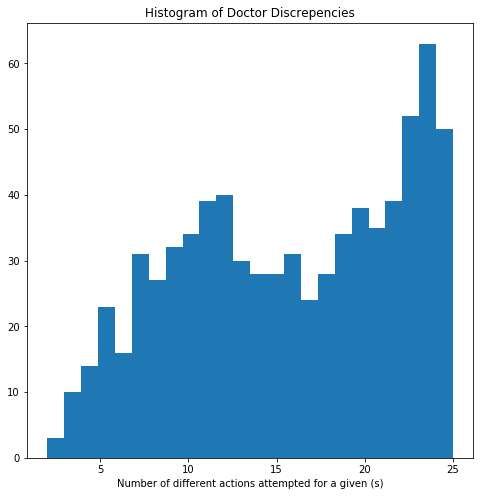

In [14]:
plt.hist(dist,bins=n_actions-1)
plt.title("Histogram of Doctor Discrepencies")
plt.xlabel("Number of different actions attempted for a given (s)")
plt.show()

In [15]:

print ("Out of {0:d} unique s,a combinations, only {1:d} had multiple actions".format(len(distinct_sas_count),len(dist)))

Out of 11841 unique s,a combinations, only 749 had multiple actions


In [158]:
np.histogram(dist,bins=n_actions-1)

(array([853, 617, 440, 389, 312, 281, 251, 191, 184, 160, 128, 127,  89,
         88,  84,  77,  61,  49,  53,  59,  42,  34,  26,  10]),
 array([  2.        ,   2.95833333,   3.91666667,   4.875     ,
          5.83333333,   6.79166667,   7.75      ,   8.70833333,
          9.66666667,  10.625     ,  11.58333333,  12.54166667,
         13.5       ,  14.45833333,  15.41666667,  16.375     ,
         17.33333333,  18.29166667,  19.25      ,  20.20833333,
         21.16666667,  22.125     ,  23.08333333,  24.04166667,  25.        ]))